# PSF Contamination Modeling Part 1: Tau and Rho Statistics Measurement

This notebook aims at measuring the $\tau$ and $\rho$ statistics that are needed to evaluation the level of additive contamination on cosmic shear two-point functions (2PCFs) due to point-spread function (PSF) modelling uncertainties. In a second notebook, we will fit a best-fitting model for each tomography bin of the source galaxy catalog and evaluate the contamination level.

The PSF residual additive shear calibration bias is expressed as a systematics term $\delta e_\mathrm{PSF}^\mathrm{sys}$ in shear estimation $\gamma^\mathrm{est}$

$$\gamma^\mathrm{est} = \gamma + \delta e_\mathrm{PSF}^\mathrm{sys} + \delta e^\mathrm{noise} \tag{1} $$

and 

$$ \delta e_\mathrm{PSF}^\mathrm{sys} = \alpha e_\mathrm{model} + \beta (e_\star - e_\mathrm{model}) + \eta (e_\star \frac{T_\star - T_\mathrm{model}}{T_\star}) \tag{2}$$
 
We define 
$$p=e_\mathrm{model}\tag{3}$$
$$q=(e_\star - e_\mathrm{model})\tag{4}$$
$$w=(e_\star \frac{T_\star - T_\mathrm{model}}{T_\star})\tag{5}$$
and we have 
$$ \delta e_\mathrm{PSF}^\mathrm{sys} = \alpha p + \beta q + \eta w \tag{6}$$

Components $p$, $q$, and $w$ can be built from the reserved star catalog of DES Y3.

This shear bias term due to PSF uncertainty propagates to the cosmic shear 2PCFs as

$$\delta \xi_\pm = \vec{u}^\mathrm{T}\cdot \rho_\mathrm{mat} \cdot \vec{u} \tag{7}$$

where $\vec{u}=(\alpha,\beta,\eta)^\mathrm{T}$ and $\rho^\mathrm{mat}_\pm$ is

$$\rho^\mathrm{mat}_\pm = \begin{bmatrix} \rho_0 & \rho_2 & \rho_5 \\\ \rho_2 & \rho_1 & \rho_4 \\\ \rho_5 & \rho_4 & \rho_3 \end{bmatrix} \tag{8}$$

where 
$$\rho_0=\langle pp\rangle \tag{9}$$
$$\rho_1=\langle qq\rangle$$
$$\rho_2=\langle qp\rangle$$
$$\rho_3=\langle ww\rangle$$
$$\rho_4=\langle wq\rangle$$
$$\rho_5=\langle wp\rangle$$
and each $\rho$ has + and - components.

To idensify the coefficients $\vec{u}$, one also need to measure the cross-correlation of PSF quantities $p,q,w$ with source galaxy shear estimates (so-called $\tau$ statistics) of each tomography bin (denoted as $i$)

$$\tau_0^i(\theta) = \langle \gamma^\mathrm{est}(x) p(x+\theta)\rangle = \alpha^i \rho_0 + \beta^i \rho_2 + \eta^i \rho_5 \tag{10}$$
$$\tau_2^i(\theta) = \langle \gamma^\mathrm{est}(x) q(x+\theta)\rangle = \alpha^i \rho_2 + \beta^i \rho_1 + \eta^i \rho_4$$
$$\tau_5^i(\theta) = \langle \gamma^\mathrm{est}(x) w(x+\theta)\rangle = \alpha^i \rho_5 + \beta^i \rho_4 + \eta^i \rho_3$$
Therefore with rho and tau statistics, the coefficients $(\alpha, \beta, \eta)$ can be determined for each tomography bin.

**Note:** That the source galaxy catalog has to be corrected for shear response

In [1]:
from DESY3Cats import DESY3Cats
import yaml
import h5py
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import fitsio as fio
from astropy.io import fits as fits
import treecorr as corr
print(f'{corr.__version__} {corr.__file__}')
from os.path import exists
import pickle
import os

def readCovmats(covs_fname, NG=True):
    covs = []
    for ct in range(len(covs_fname)):
        cov_data = np.genfromtxt(covs_fname[ct])
        Ndim = int(np.max(cov_data[:,0]) - np.min(cov_data[:,0])) + 1 
        print(f'Ndim = {Ndim}')
        cov = np.zeros((Ndim, Ndim))
        for line in range(cov_data.shape[0]):
            i, j = int(cov_data[line, 0]), int(cov_data[line, 1])
            if(cov_data.shape[1]==10):
                cg = cov_data[line, 8] if np.isfinite(cov_data[line, 8]) else 0.0
                cng = cov_data[line, 9] if np.isfinite(cov_data[line, 9]) else 0.0
                if(not np.isfinite(cov_data[line, 9])):
                    print("NG is not finite: i,j=%d,%d"%(i,j))
                if(not np.isfinite(cov_data[line, 8])):
                    print("G is not finite: i,j=%d,%d"%(i,j))
                if NG:
                    cov[i, j] = cg + cng
                    cov[j, i] = cg + cng
                else:
                    cov[i, j] = cg
                    cov[j, i] = cg
            elif(cov_data.shape[1]==3):
                cov[i, j] = cov_data[line, 2]
                cov[j, i] = cov_data[line, 2]
            else:
                print("ERROR: FORMAT UNRECOGNIZED")
                exit(-1)
        covs.append(cov)
    return covs

5.1.1 /home/jiachuan/anaconda3/lib/python3.9/site-packages/treecorr/__init__.py


In [17]:
### Load measurements from Jefferson+ 2025
rhos = h5py.File('/home/jiachuan/2pt_measurements_Y3/Jefferson2025RhoTau/rowe_stats_DESY3.hdf5', 'r')
taus = h5py.File('/home/jiachuan/2pt_measurements_Y3/Jefferson2025RhoTau/tau_stats_DESY3.hdf5', 'r')

In [11]:
### Data files used in this note book are saved in

# DES Y3 data root dir
ROOT_Y3 = "/home/jiachuan/data/jiachuan/DESY3_DR"

# DES Y3 Key Project catalog YAML file 
cats_index = ROOT_Y3+"/y3kp_cats/cats.yaml"

# DES Y3 Data Vector
y3dv_file = ROOT_Y3+"/datavectors/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits"

# dir to save related files
TARGET_DIR = "/home/jiachuan/2pt_measurements_Y3/data_planck"

# reserved star for PSF
psf_file = ROOT_Y3+"/psf_y3a1-v29.fits"

# covariance matrix
covmat_file = "/home/jiachuan/cocoa/Cocoa/projects/desy1xplanck/data/covmats/"+\
"cov_DESY3xPLKR4_mix6x2pt_baseline_8-2048_Ntheta30_withAnnulus_llllY3_kkkkPR4"
covmat = readCovmats([covmat_file])[0][:600,:600]
invcov = np.linalg.inv(covmat)

Ndim = 1809


In [3]:
# basic dict props
DESY3Cats_dict_ = {
    'output_exists' : True,
    'use_mpi'       : False,
    'source'        : 'hdf5',
    'dg'            : 0.01 #metacal applied shear
    }

# Populates a full DESY3Cats yaml dict for each catalog selection 
# based on the limited catalog input info provided in the common 
# cats.yaml file
def create_DESY3Cats_yaml( params, name, cal_type, group, table, 
                          select_path ):
    """
    Creates the input dictionary structure from a passed dictionary 
    rather than reading froma yaml file.
    """

    DESY3Cats_dict = DESY3Cats_dict_.copy()
    DESY3Cats_dict['load_cache'] = params['load_cache']
    DESY3Cats_dict['output'] = params['output']
    DESY3Cats_dict['name'] = name
    DESY3Cats_dict['filename'] = params['datafile']
    DESY3Cats_dict['param_file'] = params['param_file']
    DESY3Cats_dict['cal_type'] = cal_type
    DESY3Cats_dict['group'] = group
    DESY3Cats_dict['table'] = table
    DESY3Cats_dict['select_path'] = select_path
    DESY3Cats_dict['e'] = ['e_1','e_2']
    DESY3Cats_dict['Rg'] = ['R11','R22']
    DESY3Cats_dict['w'] = 'weight'

    return DESY3Cats_dict

# Build selector (and calibrator) classes from 
# DESY3Cats for the catalog.
def load_catalog(pipe_params, name, cal_type, group, table, select_path, 
                 inherit=None, return_calibrator=None):
    """
    Loads data access and calibration classes from DESY3Cats for 
    a given yaml setup file.
    """

    # Input yaml file defining catalog
    params = create_DESY3Cats_yaml(pipe_params, name, cal_type, group, table, 
                                   select_path)

    # Load DESY3Cats source class to manage access to file
    source = DESY3Cats.H5Source(params)

    # Load DESY3Cats selector class to manage access to data in a 
    # structured way
    if inherit is None:
        sel = DESY3Cats.Selector(params,source)
    else:
        sel = DESY3Cats.Selector(params,source,inherit=inherit)

    # Load DESY3Cats calibrator class to manage calibration of the catalog
    if return_calibrator is not None:
        cal = return_calibrator(params,sel)
        return sel, cal
    else:
        return sel

# Read yaml file that defines all the catalog selections used
params = yaml.load(open(cats_index),Loader=yaml.Loader)
params['param_file'] = cats_index

## 1 Load the reserved star and source galaxy catalogs

Load the psf catalog of researved star, and build the components $p$, $q$, and $w$. 

Note that since we want to estimate the Jacknife covariance matrix of $\tau$ statistics, we need to split the star and shear catalog into patches. Jefferson et al. (2025) suggest to split DES Y3 shape catalog into 1000 patches. Therefore we split the shear catalog S1 bin into 1000 patches and save their patch center, and recycle that patch center for source catalog of other tomography bins and also reserved star catalog. 

**Note:** The shear catalog has no objects around bright stars while the star catalog has stars identified in those regions, therefore we use shear catalog to define patches to avoid cases that no shear objects are identified in a bright star patch.

**Note:** Mike Jarvis suggests not to subtract the mean of star PSF catalog, because the mean is a true systematics here.

**Note:** DES Y3 source galaxies are selected in $riz$ bands, so we also select stars that are observed in $riz$ bands

In [4]:
psf_hdul = fits.open(psf_file)
psf_cat = psf_hdul[1].data
psf_hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  113 / width of table in bytes                        
NAXIS2  =             56707987 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   17 / number of fields in each row                   
TTYPE1  = 'ra      '           / label for field   1                            
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE2  = 'dec     '           / label for field   2                            
TFORM2  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE3  = 'x       '        

In [6]:
### build cosmic shear catalog
src_data_cats_cache_fmt = os.path.join(ROOT_Y3, "TreeCorrCat_cache/Metacal_data_response_applied.pkl")
src_shear_calib_cache_fmt = os.path.join(ROOT_Y3, "TreeCorrCat_cache/Metacal_shear_response.txt")
path_center_file = "DES_Y3_1000_patches_center.txt"

if exists(src_data_cats_cache_fmt) and False:
    print("\n---Loading Metacal TreeCorr catalog from cache %s"%src_data_cats_cache_fmt)
    with open(src_data_cats_cache_fmt, "rb") as fp:
        src_data_cats = pickle.load(fp)
    # Only Rbins, the shear response per tomo bins is used in following steps
    Rbins = np.loadtxt(src_shear_calib_cache_fmt)
else:
    # Source catalog
    source_selector, source_calibrator = load_catalog(
        params, 'mcal', 'mcal', params['source_group'], params['source_table'], 
        params['source_path'], return_calibrator=DESY3Cats.MetaCalib)

    # SOMPZ information
    pz_selector = load_catalog(
        params, 'pz', 'mcal', params['pz_group'], params['pz_table'], 
        params['pz_path'], inherit=source_selector)

    mcal_data_ra = source_selector.get_col('ra')[0]
    mcal_data_dec = source_selector.get_col('dec')[0]
    mcal_data_g1 = source_selector.get_col('e_1')[0]
    mcal_data_g2 = source_selector.get_col('e_2')[0]

    src_data_cats = []

    # Derive shear response
    Rbins = []
    wbins = []
    cbins = []
    
    # Get some source photo-z binning information, cut to range 0.1<z_mean<1.3
    # for each tomo bin
    print('\n Reducing shear response & building metacal TreeCorr.Catalog object...')
    for i in range(4):
        # 5-tuple for metacal sheared versions
        pzbin = pz_selector.get_col('bhat')
        # tomo bin selection mask for unsheared and sheared versions
        mask = [pzbin[j] == i for j in range(5)]

        # Note that get_col() returns a tuple. If its a catalog like gold, 
        # it will have length 1, but for something like metacal, it will have
        # length 5 (in the order of the table variable list passed in cats.yaml, 
        # i.e., 'unsheared', 'sheared_1p', 'sheared_1m', 'sheared_2p', 'sheared_2m')

        # Note that get_col() applies the index mask specified by the 'path' variable
        # in the cats.yaml file automatically.

        # Get responses (c, which doesn't exist for our catalogs), and weights
        # Optionally pass an additional mask to use when calculating the selection 
        # response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use 
        # return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True
        # to include the selection response. return_full=True returns the 
        # non-component-averaged version of the full response.

        # By default, the R returned is weighted shear response
        # i.e. R = <w(Rg+Rs)>/<w>
        R1,c,w = source_calibrator.calibrate('e_1', mask=mask) 
        #print(R1,c,w)
        #g1=source_selector.get_col('e_1')
        #print(len(w),[len(g1[j]) for j in range(4)])
        R2,c,w = source_calibrator.calibrate('e_2', mask=mask)
        #print(R2,c,w)

        Rbins.append((R1+R2)/2.0)
        wbins.append(w)
        cbins.append(c)

        # get masked quantities
        _ra = mcal_data_ra[mask[0]]
        _dec = mcal_data_dec[mask[0]]
        _g1 = mcal_data_g1[mask[0]]
        _g2 = mcal_data_g2[mask[0]]
        # subtract the mean shear
        _mean_shear_1 = np.average(_g1, weights=w)
        _mean_shear_2 = np.average(_g2, weights=w)
        print(f'Mean shear of tomo-bin S{i+1}: <e1> = {_mean_shear_1*1e4:.2f}x10^4 <e2> = {_mean_shear_2*1e4:.2f}x10^4')
        _g1 -= _mean_shear_1
        _g2 -= _mean_shear_2
        # apply shear response
        _g1 = _g1 / Rbins[-1]
        _g2 = _g2 / Rbins[-1]

        # construct shear catalog
        # NOTE: Sunao suggested to add wpos = np.ones(_ra.size) because otherwise, wpos=w by default
        ### create the patch center file if not exists
        if os.path.exists(path_center_file):
            cat_mcal = corr.Catalog(ra=_ra, dec=_dec, ra_units='deg', dec_units='deg', 
                                patch_centers=path_center_file,
                                g1=_g1, g2=_g2, w=w, wpos=np.ones(_ra.size))
        ### load patch center from existing one
        else:
            cat_mcal = corr.Catalog(ra=_ra, dec=_dec, ra_units='deg', dec_units='deg', 
                                npatch=1000,
                                g1=_g1, g2=_g2, w=w, wpos=np.ones(_ra.size))
            cat_mcal.write_patch_centers(path_center_file)
        src_data_cats.append(cat_mcal)
    
    with open(src_data_cats_cache_fmt, "wb") as fp:
        pickle.dump(src_data_cats, fp)
    np.savetxt(src_shear_calib_cache_fmt, Rbins)
    
    
### select stars in riz bands
riz_stars = (psf_cat['band'] == 'r') | (psf_cat['band'] == 'i') | (psf_cat['band'] == 'z')
N_riz_stars = np.sum(riz_stars)
print(f'Select {N_riz_stars} riz stars out of {len(riz_stars)} reserved stars')

psf_riz_cat = psf_cat[riz_stars]
sample_ra = psf_riz_cat['ra']
sample_dec= psf_riz_cat['dec']
### subtract the mean ?
### Mike Jarvis suggested not subtracting the mean of PSF shape becasue the mean PSF shape is a true systematic
_SUBTRACT_MEAN_PSF_SHAPE_ = False
if _SUBTRACT_MEAN_PSF_SHAPE_:
    sample_p1 = psf_riz_cat['piff_e1'] - np.mean(psf_riz_cat['piff_e1'])
    sample_p2 = psf_riz_cat['piff_e2'] - np.mean(psf_riz_cat['piff_e2'])
    sample_q1 = psf_riz_cat['obs_e1'] - psf_riz_cat['piff_e1']; sample_q1 = sample_q1 - np.mean(sample_q1)
    sample_q2 = psf_riz_cat['obs_e2'] - psf_riz_cat['piff_e2']; sample_q2 = sample_q2 - np.mean(sample_q2)
    sample_w1 = psf_riz_cat['obs_e1']*(psf_riz_cat['obs_T']-psf_riz_cat['piff_T'])/psf_riz_cat['obs_T']
    sample_w2 = psf_riz_cat['obs_e2']*(psf_riz_cat['obs_T']-psf_riz_cat['piff_T'])/psf_riz_cat['obs_T']
    sample_w1 = sample_w1 - np.mean(sample_w1)
    sample_w2 = sample_w2 - np.mean(sample_w2)
else:
    sample_p1 = psf_riz_cat['piff_e1']
    sample_p2 = psf_riz_cat['piff_e2']
    sample_q1 = psf_riz_cat['obs_e1'] - psf_riz_cat['piff_e1']
    sample_q2 = psf_riz_cat['obs_e2'] - psf_riz_cat['piff_e2']
    sample_w1 = psf_riz_cat['obs_e1']*(psf_riz_cat['obs_T']-psf_riz_cat['piff_T'])/psf_riz_cat['obs_T']
    sample_w2 = psf_riz_cat['obs_e2']*(psf_riz_cat['obs_T']-psf_riz_cat['piff_T'])/psf_riz_cat['obs_T']
    
### build star catalog
### Note: for Jacknife covariance, all the catalogs need share the same patch centers
cat_p = corr.Catalog(ra = sample_ra, dec = sample_dec, ra_units='deg', dec_units='deg', 
                     patch_centers=path_center_file,
                     g1 = sample_p1, g2 = sample_p2)
cat_q = corr.Catalog(ra = sample_ra, dec = sample_dec, ra_units='deg', dec_units='deg', 
                     patch_centers=path_center_file,
                     g1 = sample_q1, g2 = sample_q2)
cat_w = corr.Catalog(ra = sample_ra, dec = sample_dec, ra_units='deg', dec_units='deg', 
                     patch_centers=path_center_file,
                     g1 = sample_w1, g2 = sample_w2)

[H5Source] Building HDF file from DESY3_indexcat.h5
Group: catalog/metacal
Table: ['unsheared', 'sheared_1p', 'sheared_1m', 'sheared_2p', 'sheared_2m']
The table has 37 columns:
--- R11
--- R12
--- R21
--- R22
--- T
--- T_err
--- coadd_object_id
--- covmat_0_1
--- covmat_1_1
--- covmat_2_2
--- dec
--- e_1
--- e_2
--- flags
--- flux_err_i
--- flux_err_r
--- flux_err_z
--- flux_i
--- flux_r
--- flux_z
--- mask_frac
--- mcal_psf_T
--- mcal_psf_e1
--- mcal_psf_e2
--- nimage_tot_i
--- nimage_tot_r
--- nimage_tot_z
--- nimage_use_i
--- nimage_use_r
--- nimage_use_z
--- psf_T
--- psf_e1
--- psf_e2
--- ra
--- size_ratio
--- snr
--- weight
The table has 399263026 rows
Sheared table detected! Sheared table has 16 columns:
--- T
--- T_err
--- covmat_0_1
--- covmat_1_1
--- covmat_2_2
--- e_1
--- e_2
--- flux_err_i
--- flux_err_r
--- flux_err_z
--- flux_i
--- flux_r
--- flux_z
--- size_ratio
--- snr
--- weight
[Selector] Building limiting mask...
[Selector] params index file from DESY3_indexcat.h5


Let's have a look at the patches

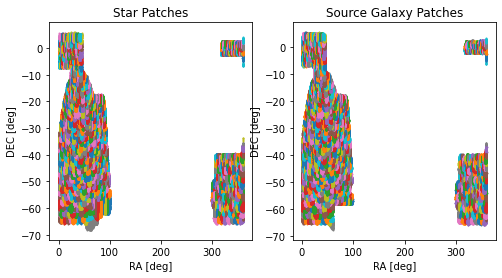

In [16]:
fig, axes = plt.subplots(1,2,figsize=(8,4))

for patch_id in range(1000):
    # star patch
    m = (cat_p.patch == patch_id)
    axes[0].scatter(cat_p.ra[m][::100]/np.pi*180, cat_p.dec[m][::100]/np.pi*180, s=1)
    # galaxy patch
    cat = src_data_cats[0]
    m = (cat.patch == patch_id)
    axes[1].scatter(cat.ra[m][::100]/np.pi*180, cat.dec[m][::100]/np.pi*180, s=1)
axes[0].set(title='Star Patches')
axes[1].set(title='Source Galaxy Patches')
axes[0].set(xlabel='RA [deg]', ylabel='DEC [deg]')
axes[1].set(xlabel='RA [deg]', ylabel='DEC [deg]')
plt.show()

## 2. Measure the $\rho$ and $\tau$ statistics

In [9]:
gg = corr.GGCorrelation(min_sep=0.25, max_sep=250, nbins=30, sep_units='arcmin', bin_slop=0.,
                        num_threads=8, cross_patch_weight='match')

cats = [cat_p, cat_q, cat_w]
labs = ["p", "q", "w"]
### Measurement of rho statistics
for i in range(3):
    for j in range(i+1):
        if j==0:
            gg.process(cats[i])
        else:
            gg.process(cats[i], cats[i-j])
        cov_jk = gg.estimate_cov('jackknife')
        print('Rho-stars: <%s-%s> done!'%(labs[i], labs[i-j]))
        gg.write(TARGET_DIR+f'/rho_stats_{labs[i]}{labs[i-j]}_riz_Ntheta30_v3.txt')
        np.savetxt(TARGET_DIR+f'/rho_covmat_{labs[i]}{labs[i-j]}_riz_Ntheta30_v3.txt', cov_jk)
### Measurement of tau statistics
### ** Note **: shear response has been applied inside the catalog object
tau0 = corr.GGCorrelation(min_sep=0.25, max_sep=250, nbins=30, sep_units='arcmin', bin_slop=0.,
                        num_threads=8, cross_patch_weight='match')
tau2 = corr.GGCorrelation(min_sep=0.25, max_sep=250, nbins=30, sep_units='arcmin', bin_slop=0.,
                        num_threads=8, cross_patch_weight='match')
tau5 = corr.GGCorrelation(min_sep=0.25, max_sep=250, nbins=30, sep_units='arcmin', bin_slop=0.,
                        num_threads=8, cross_patch_weight='match')
for j in range(4):
    print(f'Measuring tau statis for source bin {j+1}')
    tau0.process(cat_p, src_data_cats[j])
    tau0.write(TARGET_DIR+f'/tau_stats_p-S{j}_riz_Ntheta30_v3.txt')
    print('Tau-stats: <p-S%d> done!'%(j+1))
    tau2.process(cat_q, src_data_cats[j])
    tau2.write(TARGET_DIR+f'/tau_stats_q-S{j}_riz_Ntheta30_v3.txt')
    print('Tau-stats: <q-S%d> done!'%(j+1))
    tau5.process(cat_w, src_data_cats[j])
    tau5.write(TARGET_DIR+f'/tau_stats_w-S{j}_riz_Ntheta30_v3.txt')
    print('Tau-stats: <w-S%d> done!'%(j+1))
    ### estimate the covariance between tau0/2/5 pm
    ### covariance is in sequence of tau0p, tau0m, tao2p, tau2m, tau5p, tau5m
    cov_jk = corr.estimate_multi_cov([tau0, tau2, tau5], 'jackknife')
    print('Tau-stat covariance: <S%d> done!'%(j+1))
    np.savetxt(TARGET_DIR+f'/tau_covmat_S{j}_riz_Ntheta30_v3.txt', cov_jk)

Rho-stars: <p-p> done!
Rho-stars: <q-q> done!
Rho-stars: <q-p> done!
Rho-stars: <w-w> done!
Rho-stars: <w-q> done!
Rho-stars: <w-p> done!
Measuring tau statis for source bin 1
Tau-stats: <p-S1> done!
Tau-stats: <q-S1> done!
Tau-stats: <w-S1> done!
Tau-stat covariance: <S1> done!
Measuring tau statis for source bin 2
Tau-stats: <p-S2> done!
Tau-stats: <q-S2> done!
Tau-stats: <w-S2> done!
Tau-stat covariance: <S2> done!
Measuring tau statis for source bin 3
Tau-stats: <p-S3> done!
Tau-stats: <q-S3> done!
Tau-stats: <w-S3> done!
Tau-stat covariance: <S3> done!
Measuring tau statis for source bin 4
Tau-stats: <p-S4> done!
Tau-stats: <q-S4> done!
Tau-stats: <w-S4> done!
Tau-stat covariance: <S4> done!


## 3. Visualize the $\rho$ and $\tau$ statistics measured

In [18]:
rho_stats = []
rho_riz_stats = []
tau_riz_stats = []
components = ['p', 'q', 'w']
for i in range(3):
    for j in range(i+1):
        print(components[i], components[i-j])
        rho_riz = np.genfromtxt(TARGET_DIR+"/rho_stats_%s%s_riz_Ntheta30_v3.txt"%(components[i], components[i-j]), 
                            names=True, skip_header=1)
        rho_riz_stats.append(rho_riz)
        rho = np.genfromtxt(TARGET_DIR+"/%s%s_Ntheta30.txt"%(components[i], components[i-j]), 
                            names=True, skip_header=1)
        rho_stats.append(rho)
for i in range(4):
    _tau_riz_stats = []
    for j in range(3):
        print(components[j], f'S{i+1}')
        tau_riz = np.genfromtxt(TARGET_DIR+"/tau_stats_%s-S%d_riz_Ntheta30_v3.txt"%(components[j], i), 
                            names=True, skip_header=1)
        _tau_riz_stats.append(tau_riz)
    tau_riz_stats.append(_tau_riz_stats)
### Load the jacknife covariance
tau_riz_cov = []
for i in range(4):
    data = np.genfromtxt(TARGET_DIR+f'/tau_covmat_S{i}_riz_Ntheta30_v3.txt')
    tau_riz_cov.append(data)

p p
q q
q p
w w
w q
w p
p S1
q S1
w S1
p S2
q S2
w S2
p S3
q S3
w S3
p S4
q S4
w S4


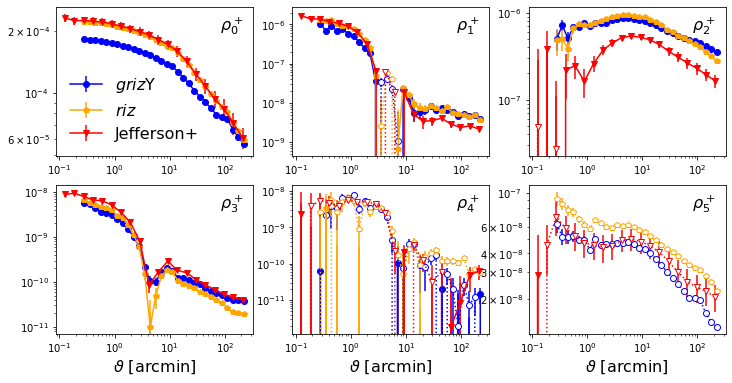

In [19]:
fig, axes = plt.subplots(2,3,figsize=(12,6))

for i in range(6):
    ax = axes[i//3, i%3]
    
    ### grizY rho stats, for comparizon
    rho = rho_stats[i]
    ax.errorbar(rho['r_nom'], rho['xip'], yerr=rho['sigma_xip'], ls='-', color='blue',
                marker='o', label='$griz$Y')
    ax.errorbar(rho['r_nom'], -rho['xip'], yerr=rho['sigma_xip'], ls=':', color='blue', 
                marker='o', mfc='white')
    
    ### riz rho statis
    rho_riz = rho_riz_stats[i]
    ax.errorbar(rho_riz['r_nom'], rho_riz['xip'], yerr=rho_riz['sigma_xip'], ls='-', 
                color='orange', marker='p', label='$riz$')
    ax.errorbar(rho_riz['r_nom'], -rho_riz['xip'], yerr=rho_riz['sigma_xip'], ls=':', color='orange', 
                marker='p', mfc='white')
    
    ### rho stats in Jefferson+ 2025
    ### Note that Jefferson use different theta-bin scheme
    rho_jefferson = rhos['rowe_statistics'][f'rowe_{i}_PSF-reserved']
    ax.errorbar(rho_jefferson['theta'][:], rho_jefferson['xi_plus'][:], yerr=rho_jefferson['xip_err'][:], ls='-',
               color='red', marker='v', label='Jefferson+')
    ax.errorbar(rho_jefferson['theta'][:], -rho_jefferson['xi_plus'][:], yerr=rho_jefferson['xip_err'][:], ls=':',
               color='red', marker='v', mfc='white')
    
    ax.text(0.95, 0.95, r'$\rho^+_'f'{i}'r'$', transform=ax.transAxes, fontsize=16, ha='right', va='top')
    ax.set(xscale='log', yscale='log')
    if i//3==1:
        ax.set_xlabel(r'$\vartheta$ [arcmin]', fontsize=16)
axes[0,0].legend(loc='lower left', fontsize=16, frameon=False)
plt.show()

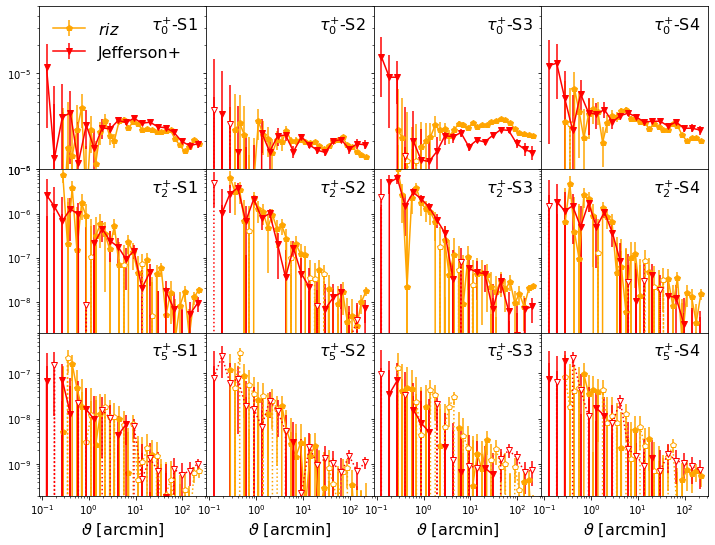

In [20]:
fig, axes = plt.subplots(3,4,figsize=(12,9), sharey=False)

for i in range(4):
    for j in range(3):
        ax = axes[j, i]
        
        ### Tau from riz
        tau_riz = tau_riz_stats[i][j]
        ax.errorbar(tau_riz['r_nom'], tau_riz['xip'], yerr=tau_riz['sigma_xip'], ls='-', 
                    color='orange', marker='p', label='$riz$')
        ax.errorbar(tau_riz['r_nom'], -tau_riz['xip'], yerr=tau_riz['sigma_xip'], ls=':', 
                    color='orange', marker='p', mfc='white')
        
        ### Tau from Jefferson
        ### Note that Jefferson use different theta-bin scheme
        tau_jefferson = taus['tau_statistics']['tau_PSF-reserved'][f'bin_{i}']
        tag = ['tau0p', 'tau2p', 'tau5p'][j]
        tau_err_jefferson = np.diag(taus['tau_statistics']['tau_PSF-reserved'][f'bin_{i}']['cov'][:])**0.5
        ax.errorbar(tau_jefferson['theta'][:], tau_jefferson[tag][:], 
                    yerr=tau_err_jefferson[j*40+20:(j+1)*40], ls='-',
                   color='red', marker='v', label='Jefferson+')
        ax.errorbar(tau_jefferson['theta'][:], -tau_jefferson[tag][:], 
                    yerr=tau_err_jefferson[j*40+20:(j+1)*40], ls=':',
                   color='red', marker='v', mfc='white')

        ax.text(0.95, 0.95, r'$\tau_'f'{[0,2,5][j]}'r'^{+}$-S%d'%(i+1), 
                transform=ax.transAxes, fontsize=16, ha='right', va='top')
        ax.set(xscale='log', yscale='log')
        if j==2:
            ax.set_xlabel(r'$\vartheta$ [arcmin]', fontsize=16)
        else:
            ax.set(xticklabels=[])
        if j==0:
            ax.set(ylim=[1e-6, 5e-5])
        elif j==1:
            ax.set(ylim=[2e-9, 1e-5])
        elif j==2:
            ax.set(ylim=[2e-10, 8e-7])
        if i!=0:
            ax.set(yticklabels=[])
axes[0,0].legend(loc='upper left', fontsize=16, frameon=False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

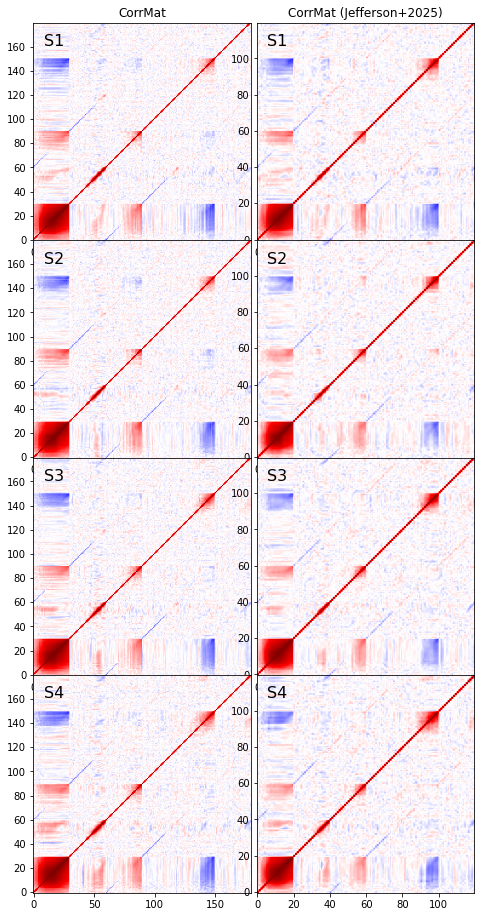

In [24]:
### Show & compare the covariance matrix
fig, axes = plt.subplots(4,2,figsize=(8,16))
for i in range(4):
    cov_Jefferson = taus['tau_statistics']['tau_PSF-reserved'][f'bin_{i}']['cov'][:]
    cov = tau_riz_cov[i]
    axes[i,0].imshow(cov/np.sqrt(np.outer(np.diag(cov), np.diag(cov))), 
                   cmap='seismic', vmin=-1, vmax=1, origin='lower')
    axes[i,0].text(0.05,0.95,f'S{i+1}',transform=axes[i,0].transAxes,fontsize=16, va='top', ha='left')
    axes[i,1].imshow(cov_Jefferson/np.sqrt(np.outer(np.diag(cov_Jefferson), np.diag(cov_Jefferson))), 
               cmap='seismic', vmin=-1, vmax=1, origin='lower')
    axes[i,1].text(0.05,0.95,f'S{i+1}',transform=axes[i,1].transAxes,fontsize=16, va='top', ha='left')
axes[0,0].set(title='CorrMat')
axes[0,1].set(title='CorrMat (Jefferson+2025)')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

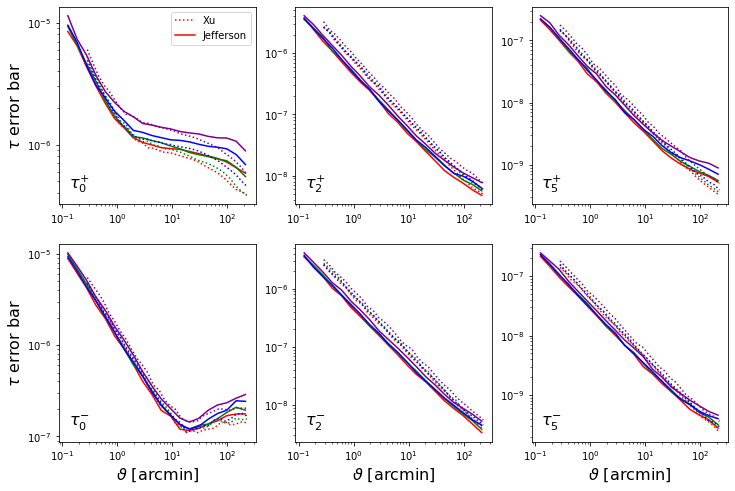

In [42]:
### Show & compare the covariance matrix diagonal part
r_Jefferson = taus['tau_statistics']['tau_PSF-reserved'][f'bin_{0}']['theta'][:]
r_edge = np.logspace(np.log10(0.25), np.log10(250), 31)
r = 2/3*(r_edge[1:]**3 - r_edge[:-1]**3)/(r_edge[1:]**2 - r_edge[:-1]**2)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i in range(4):
    color = ['r', 'g', 'b', 'purple'][i]
    cov_Jefferson = taus['tau_statistics']['tau_PSF-reserved'][f'bin_{i}']['cov'][:]
    cov = tau_riz_cov[i]
    std_Jefferson = np.diag(cov_Jefferson)**0.5
    std = np.diag(cov)**0.5
    
    for k in range(3):
        for j in range(2):
            ax = axes[j,k]
            start,end = k*2+j, k*2+j+1
            
            ax.loglog(r, std[start*30:end*30], label='Xu' if i==0 else '', ls=':', color=color)
            ax.loglog(r_Jefferson, std_Jefferson[start*20:end*20], label='Jefferson' if i==0 else '',
                     color=color)
            if i ==0:
                tau_id = [0,2,5][k]
                pm = ['+', '-'][j]
                ax.text(0.05, 0.05, r'$\tau_{' + f'{tau_id}' + r'}^{' + f'{pm}' + r'}$', transform=ax.transAxes,
                       ha='left', va='bottom', fontsize=16)
axes[0,0].legend()
for k in range(3):
    axes[1,k].set_xlabel(r'$\vartheta$ [arcmin]', fontsize=16)
for j in range(2):
    axes[j,0].set_ylabel(r'$\tau$ error bar', fontsize=16)

plt.show()

## 4. Plot example impact of PSF contaminations v.s. Cosmic shear 2PCF measurement

The best-fitting coefficients are shown in Amon+22 Table IV. 

### contamination v.s. Y3 measurement

Ndata = 600
dchi2 generated by the additive bias due to PSF modeling uncertainty: 1.050563224138954


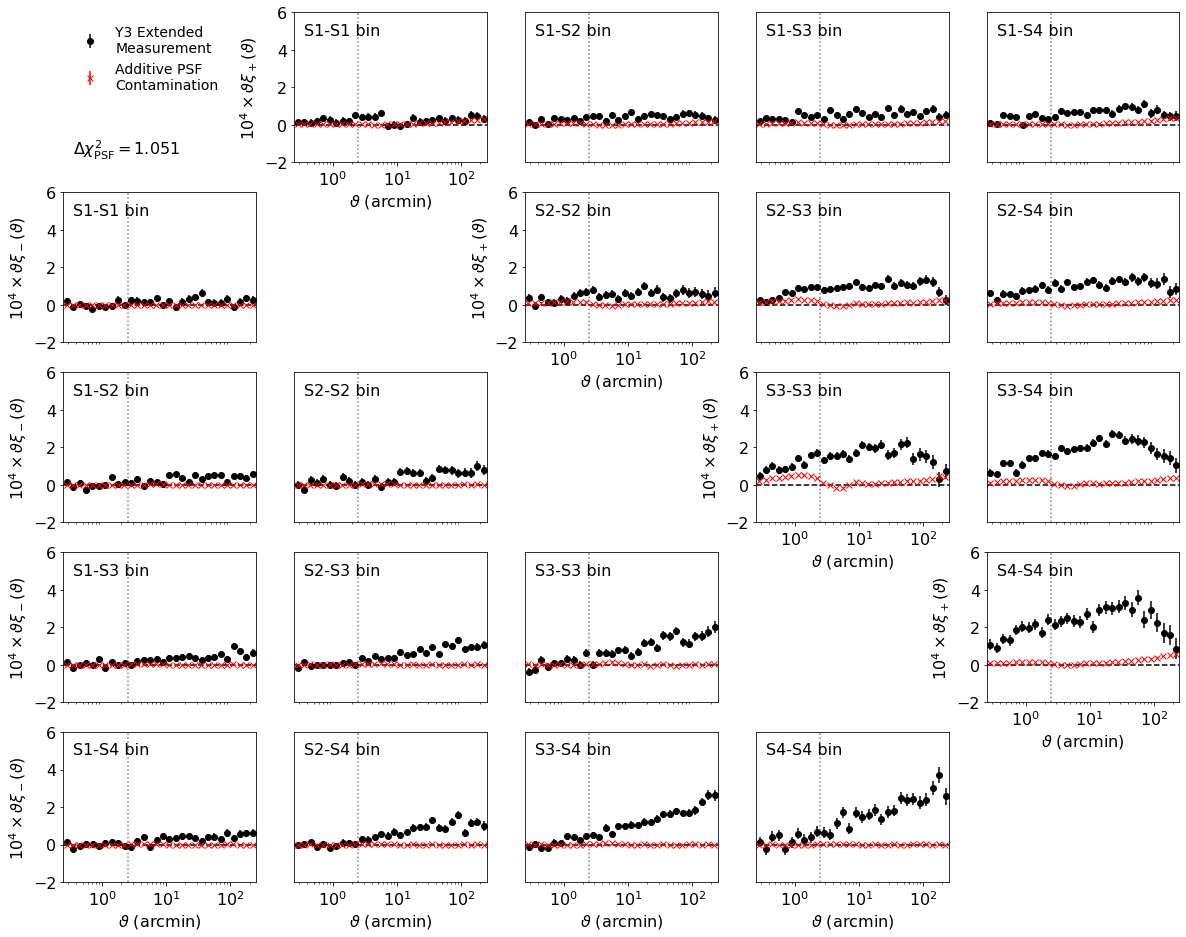

In [25]:
fig = plt.figure(figsize=(20, 16))

ct = 0
lines = []
additive_bias = []
pp = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_pp_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
qq = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_qq_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
qp = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_qp_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
ww = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_ww_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
wq = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_wq_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
wp = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_wp_riz_Ntheta30_v3.txt"), names=True, skip_header=1)

rhomat_r = pp["r_nom"]
rhomat_p = np.array([[pp['xip'], qp['xip'], wp['xip']], 
                     [qp['xip'], qq['xip'], wq['xip']], 
                     [wp['xip'], wq['xip'], ww['xip']]])
rhomat_m = np.array([[pp['xim'], qp['xim'], wp['xim']], 
                     [qp['xim'], qq['xim'], wq['xim']], 
                     [wp['xim'], wq['xim'], ww['xim']]])
rhomat_pvar = np.array([[pp['sigma_xip']**2, qp['sigma_xip']**2, wp['sigma_xip']**2], 
                        [qp['sigma_xip']**2, qq['sigma_xip']**2, wq['sigma_xip']**2], 
                        [wp['sigma_xip']**2, wq['sigma_xip']**2, ww['sigma_xip']**2]])
rhomat_mvar = np.array([[pp['sigma_xim']**2, qp['sigma_xim']**2, wp['sigma_xim']**2], 
                        [qp['sigma_xim']**2, qq['sigma_xim']**2, wq['sigma_xim']**2], 
                        [wp['sigma_xim']**2, wq['sigma_xim']**2, ww['sigma_xim']**2]])

alphas = [0.010, -0.001, -0.004, 0.014]
betas = [0.6, 1.4, 2.5, 1.3]
etas = [-4.6, -4.5, 3.0, 4.2]

### show shear-shear xi+
for i in range(4):
    for j in range(i,4):
        ax = plt.subplot2grid((5, 5), (i,j+1))
        ax.text(0.05,0.85,'S%d-S%d bin'%(i+1, j+1),transform=ax.transAxes, fontsize=16)
        
        ### Read Real Measurements
        ### Updates (Apr 28, 2025): the cosmic shear measurements plotted below includes the updated sompz v5
        xi_s = np.genfromtxt(os.path.join(TARGET_DIR, "shear_small-scale_withIm_%d_%d.txt"%(i,j)), names=True)
        xi_l = np.genfromtxt(os.path.join(TARGET_DIR, "shear_withIm_%d_%d.txt"%(i,j)), names=True)
        yerr_s = np.sqrt(np.diag(covmat))[ct:ct+10]
        yerr_l = np.sqrt(np.diag(covmat))[ct+10:ct+30]
        _l1 = ax.errorbar(xi_s['r'], 1e4*xi_s['r']*xi_s['xip'], 
                          yerr=1e4*xi_s['r']*yerr_s, 
                          fmt='ok')
        ax.errorbar(xi_l['r'], 1e4*xi_l['r']*xi_l['xip'], 
                    yerr=1e4*xi_l['r']*yerr_l, 
                    fmt='ok')
        
        ### Read PSF contaminations
        coef1 = np.array([alphas[i], betas[i], etas[i]])
        coef2 = np.array([alphas[j], betas[j], etas[j]])
        y = np.array([coef1@rhomat_p[:,:,k]@coef2 for k in range(len(pp))])
        additive_bias.append(y)
        yerr = np.array([coef1@rhomat_pvar[:,:,k]@coef2 for k in range(len(pp))])**0.5
        
        _l2 = ax.errorbar(rhomat_r, 1e4*rhomat_r*y*10, yerr=1e4*rhomat_r*yerr*10, fmt='xr')
        
        ax.axvline(2.5, ls=':', color='grey')
        
        ### Y3 Scale cut mask
#         _m = np.where(mask[ct:ct+30]<0.5)[0]
#         _x = thetas[_m]
#         _x[-1] *= 1.12
#         _x[0] /= 1.12
#         ax.fill_between(_x, -10, 10, color='lightgrey', alpha=0.5)
#         ax.fill_between([0, 2.5], -10, 10, color='silver', alpha=0.5)
#         ax.fill_between([0, 1], -10, 10, color='darkgrey', alpha=0.5)
#         ax.fill_between([0, 0.5], -10, 10, color='dimgrey', alpha=0.5)
        
        ### Plot customization
        ax.set(xscale='log')
        if(j==i):
            ax.set_ylabel(r'$10^{4}\times\vartheta\xi_+(\vartheta)$', fontsize=16)
            ax.set_xlabel(r'$\vartheta$ (arcmin)', fontsize=16)
            ax.tick_params(axis='both', which='major', labelsize=16)
        else:
            ax.set_yticks([])
            ax.set_xticks([])
        ax.set_ylim([-2,6])
        ax.set_xlim([0.25, 250])
        ax.axhline(0, ls='--', color='k')
        ct+=30
        ### set figure legend
        if(i==0 and j==0):
            lines = [_l1, _l2]
            linelabels = ["Y3 Extended\nMeasurement", 
                          "Additive PSF \nContamination"]
            legend_ax = plt.subplot2grid((5, 5), (i,j))
            legend_ax.axis('off')
            legend_ax.legend(lines, linelabels, fontsize=14, loc='upper left', frameon=False)
### show shear-shear xi-
for i in range(4):
    for j in range(i,4):
        ax = plt.subplot2grid((5, 5), (j+1,i))
        ax.text(0.05,0.85,'S%d-S%d bin'%(i+1, j+1),transform=ax.transAxes, fontsize=16)
        
        
        ### Read Real Measurements
        xi_s = np.genfromtxt(os.path.join(TARGET_DIR, "shear_small-scale_withIm_%d_%d.txt"%(i,j)), names=True)
        xi_l = np.genfromtxt(os.path.join(TARGET_DIR, "shear_withIm_%d_%d.txt"%(i,j)), names=True)
        yerr_s = np.sqrt(np.diag(covmat))[ct:ct+10]
        yerr_l = np.sqrt(np.diag(covmat))[ct+10:ct+30]
        ax.errorbar(xi_s['r'], 1e4*xi_s['r']*xi_s['xim'], 
                    yerr=1e4*xi_s['r']*yerr_s, 
                    fmt='ok')
        ax.errorbar(xi_l['r'], 1e4*xi_l['r']*xi_l['xim'], 
                    yerr=1e4*xi_l['r']*yerr_l, 
                    fmt='ok')
        
        ### Read PSF contaminations
        coef1 = np.array([alphas[i], betas[i], etas[i]])
        coef2 = np.array([alphas[j], betas[j], etas[j]])
        y = np.array([coef1@rhomat_m[:,:,k]@coef2 for k in range(len(pp))])
        additive_bias.append(y)
        yerr = np.array([coef1@rhomat_mvar[:,:,k]@coef2 for k in range(len(pp))])**0.5
        
        ax.errorbar(rhomat_r, 1e4*rhomat_r*y*10, yerr=1e4*rhomat_r*yerr*10, fmt='xr')
        
        ax.axvline(2.5, ls=':', color='grey')
            
        ### Y3 Scale-cut mask
#         _m = np.where(mask[ct:ct+30]<0.5)[0]
#         _x = thetas[_m]
#         _x[-1] *= 1.12
#         _x[0] /= 1.12
#         ax.fill_between(_x, -10, 10, color='lightgrey', alpha=0.5)
#         ax.fill_between([0, 2.5], -10, 10, color='silver', alpha=0.5)
#         ax.fill_between([0, 1], -10, 10, color='darkgrey', alpha=0.5)
#         ax.fill_between([0, 0.5], -10, 10, color='dimgrey', alpha=0.5)
        
        ### Plot customization
        ax.set(xscale='log')
        if(i==0):
            ax.set_ylabel(r'$10^{4}\times\vartheta\xi_-(\vartheta)$', fontsize=16)
            ax.tick_params(axis='y', which='major', labelsize=16)
        else:
            ax.set_yticks([])
        if(j==3):
            ax.set_xlabel(r'$\vartheta$ (arcmin)', fontsize=16)
            ax.tick_params(axis='x', which='major', labelsize=16)
        else:
            ax.set_xticks([])
        ax.set_ylim([-2,6])
        ax.set_xlim([0.25, 250])
        ax.axhline(0, ls='--', color='k')
        ct += 30
        

print("Ndata = {}".format(ct))
additive_bias = np.hstack(additive_bias)
dchi2_due_to_additive_bias = additive_bias@invcov@additive_bias
print(f'dchi2 generated by the additive bias due to PSF modeling uncertainty: {dchi2_due_to_additive_bias}')
legend_ax.text(0.05, 0.05, r'$\Delta \chi^2_\mathrm{PSF}=$%.3f'%dchi2_due_to_additive_bias, 
               fontsize=16, transform=legend_ax.transAxes)
plt.show()
#plt.savefig('figs/Y3_xipm_Ntheta30_additive_bias.png', dpi=300, facecolor="white")

Ndata = 600


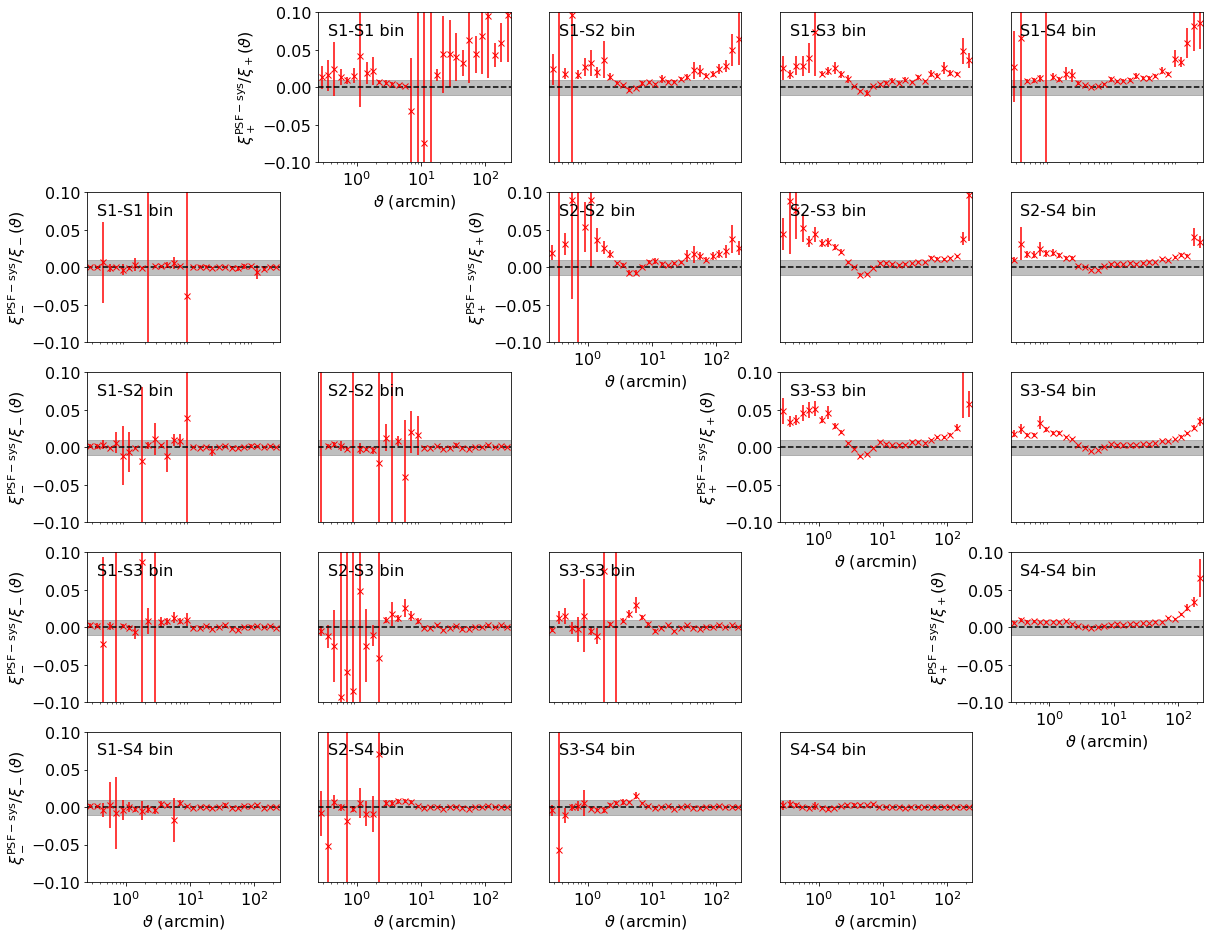

In [26]:
fig = plt.figure(figsize=(20, 16))

ct = 0
lines = []

pp = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_pp_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
qq = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_qq_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
qp = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_qp_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
ww = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_ww_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
wq = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_wq_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
wp = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_wp_riz_Ntheta30_v3.txt"), names=True, skip_header=1)

rhomat_r = pp["r_nom"]
rhomat_p = np.array([[pp['xip'], qp['xip'], wp['xip']], 
                     [qp['xip'], qq['xip'], wq['xip']], 
                     [wp['xip'], wq['xip'], ww['xip']]])
rhomat_m = np.array([[pp['xim'], qp['xim'], wp['xim']], 
                     [qp['xim'], qq['xim'], wq['xim']], 
                     [wp['xim'], wq['xim'], ww['xim']]])
rhomat_pvar = np.array([[pp['sigma_xip']**2, qp['sigma_xip']**2, wp['sigma_xip']**2], 
                        [qp['sigma_xip']**2, qq['sigma_xip']**2, wq['sigma_xip']**2], 
                        [wp['sigma_xip']**2, wq['sigma_xip']**2, ww['sigma_xip']**2]])
rhomat_mvar = np.array([[pp['sigma_xim']**2, qp['sigma_xim']**2, wp['sigma_xim']**2], 
                        [qp['sigma_xim']**2, qq['sigma_xim']**2, wq['sigma_xim']**2], 
                        [wp['sigma_xim']**2, wq['sigma_xim']**2, ww['sigma_xim']**2]])

alphas = [0.010, -0.001, -0.004, 0.014]
betas = [0.6, 1.4, 2.5, 1.3]
etas = [-4.6, -4.5, 3.0, 4.2]

### show shear-shear xi+
for i in range(4):
    for j in range(i,4):
        ax = plt.subplot2grid((5, 5), (i,j+1))
        ax.text(0.05,0.85,'S%d-S%d bin'%(i+1, j+1),transform=ax.transAxes, fontsize=16)
        
        ### Read Real Measurements
        xi_s = np.genfromtxt(os.path.join(TARGET_DIR, "shear_small-scale_%d_%d.txt"%(i,j)), names=True)
        xi_l = np.genfromtxt(os.path.join(TARGET_DIR, "shear_%d_%d.txt"%(i,j)), names=True)
        r = np.hstack([xi_s['r'], xi_l['r']])
        xi = np.hstack([xi_s['xip'], xi_l['xip']])
        xivar = np.hstack([xi_s["varxip"], xi_l["varxip"]])
        ### Read PSF contaminations
        coef1 = np.array([alphas[i], betas[i], etas[i]])
        coef2 = np.array([alphas[j], betas[j], etas[j]])
        y = np.array([coef1@rhomat_p[:,:,k]@coef2 for k in range(len(pp))])
        yvar = np.array([coef1@rhomat_pvar[:,:,k]@coef2 for k in range(len(pp))])
        
        ratio_err = y/xi*np.sqrt(xivar/xi**2 + yvar/y**2)
        
        _l1 = ax.errorbar(r, y/xi, yerr=ratio_err, fmt='xr', label='Additive Bias/2PCF')
        ax.fill_between([0,300], -0.01, 0.01, color='grey', alpha=0.5)
            
        ### Y3 Scale cut mask
#         _m = np.where(mask[ct:ct+30]<0.5)[0]
#         _x = thetas[_m]
#         _x[-1] *= 1.12
#         _x[0] /= 1.12
#         ax.fill_between(_x, -10, 10, color='lightgrey', alpha=0.5)
#         ax.fill_between([0, 2.5], -10, 10, color='silver', alpha=0.5)
#         ax.fill_between([0, 1], -10, 10, color='darkgrey', alpha=0.5)
#         ax.fill_between([0, 0.5], -10, 10, color='dimgrey', alpha=0.5)
        
        ### Plot customization
        ax.set(xscale='log')
        if(j==i):
            ax.set_ylabel(r'$\xi^\mathrm{PSF-sys}_+/\xi_+(\vartheta)$', fontsize=16)
            ax.set_xlabel(r'$\vartheta$ (arcmin)', fontsize=16)
            ax.tick_params(axis='both', which='major', labelsize=16)
        else:
            ax.set_yticks([])
            ax.set_xticks([])
        ax.set_ylim([-0.1,0.1])
        ax.set_xlim([0.25, 250])
        ax.axhline(0, ls='--', color='k')
        ct+=30
        ### set figure legend
#         if(i==0 and j==0):
#             lines = [_l1, ]
#             linelabels = ["Y3 Extended\nMeasurement", 
#                           "Additive PSF \nContamination"]
#             legend_ax = plt.subplot2grid((5, 5), (i,j))
#             legend_ax.axis('off')
#             legend_ax.legend(lines, linelabels, fontsize=14, loc='upper left', frameon=False)
### show shear-shear xi-
for i in range(4):
    for j in range(i,4):
        ax = plt.subplot2grid((5, 5), (j+1,i))
        ax.text(0.05,0.85,'S%d-S%d bin'%(i+1, j+1),transform=ax.transAxes, fontsize=16)
        
        
        ### Read Real Measurements
        
        xi_s = np.genfromtxt(os.path.join(TARGET_DIR, "shear_small-scale_%d_%d.txt"%(i,j)), names=True)
        xi_l = np.genfromtxt(os.path.join(TARGET_DIR, "shear_%d_%d.txt"%(i,j)), names=True)
        r = np.hstack([xi_s['r'], xi_l['r']])
        xi = np.hstack([xi_s['xim'], xi_l['xim']])
        xivar = np.hstack([xi_s["varxim"], xi_l["varxim"]])
        ### Read PSF contaminations
        coef1 = np.array([alphas[i], betas[i], etas[i]])
        coef2 = np.array([alphas[j], betas[j], etas[j]])
        y = np.array([coef1@rhomat_m[:,:,k]@coef2 for k in range(len(pp))])
        yvar = np.array([coef1@rhomat_mvar[:,:,k]@coef2 for k in range(len(pp))])
        
        ratio_err = y/xi*np.sqrt(xivar/xi**2 + yvar/y**2)
        
        ax.errorbar(rhomat_r, y/xi, yerr=ratio_err, fmt='xr')
        ax.fill_between([0,300], -0.01, 0.01, color='grey', alpha=0.5)
        ### Y3 Scale-cut mask
#         _m = np.where(mask[ct:ct+30]<0.5)[0]
#         _x = thetas[_m]
#         _x[-1] *= 1.12
#         _x[0] /= 1.12
#         ax.fill_between(_x, -10, 10, color='lightgrey', alpha=0.5)
#         ax.fill_between([0, 2.5], -10, 10, color='silver', alpha=0.5)
#         ax.fill_between([0, 1], -10, 10, color='darkgrey', alpha=0.5)
#         ax.fill_between([0, 0.5], -10, 10, color='dimgrey', alpha=0.5)
        
        ### Plot customization
        ax.set(xscale='log')
        if(i==0):
            ax.set_ylabel(r'$\xi^\mathrm{PSF-sys}_-/\xi_-(\vartheta)$', fontsize=16)
            ax.tick_params(axis='y', which='major', labelsize=16)
        else:
            ax.set_yticks([])
        if(j==3):
            ax.set_xlabel(r'$\vartheta$ (arcmin)', fontsize=16)
            ax.tick_params(axis='x', which='major', labelsize=16)
        else:
            ax.set_xticks([])
        ax.set_ylim([-0.1,0.1])
        ax.set_xlim([0.25, 250])
        ax.axhline(0, ls='--', color='k')
        ct += 30
        

print("Ndata = {}".format(ct))

plt.show()
#plt.savefig('figs/Y3_xipm_Ntheta30_additive_bias_ratio.png', dpi=300, transparent=False, facecolor="white")

### contamination v.s. fiducial cosmic shear 2PCFs

Ndata = 600


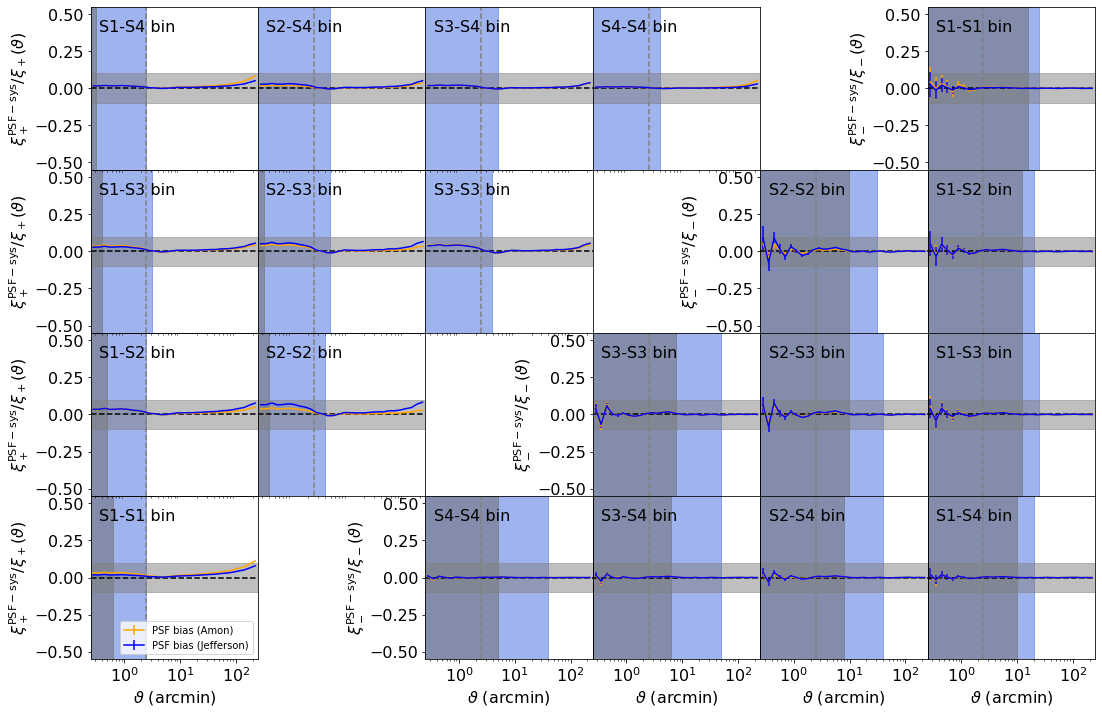

In [27]:
fig = plt.figure(figsize=(18, 12))

use_real_data = False

thetas_edge = np.logspace(np.log10(0.25), np.log10(250), 31)
thetas = np.sqrt(thetas_edge[1:]*thetas_edge[:-1])

ct = 0
lines = []

pp = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_pp_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
qq = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_qq_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
qp = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_qp_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
ww = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_ww_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
wq = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_wq_riz_Ntheta30_v3.txt"), names=True, skip_header=1)
wp = np.genfromtxt(os.path.join(TARGET_DIR, "rho_stats_wp_riz_Ntheta30_v3.txt"), names=True, skip_header=1)

rhomat_r = pp["r_nom"]
rhomat_p = np.array([[pp['xip'], qp['xip'], wp['xip']], 
                     [qp['xip'], qq['xip'], wq['xip']], 
                     [wp['xip'], wq['xip'], ww['xip']]])
rhomat_m = np.array([[pp['xim'], qp['xim'], wp['xim']], 
                     [qp['xim'], qq['xim'], wq['xim']], 
                     [wp['xim'], wq['xim'], ww['xim']]])
rhomat_pvar = np.array([[pp['sigma_xip']**2, qp['sigma_xip']**2, wp['sigma_xip']**2], 
                        [qp['sigma_xip']**2, qq['sigma_xip']**2, wq['sigma_xip']**2], 
                        [wp['sigma_xip']**2, wq['sigma_xip']**2, ww['sigma_xip']**2]])
rhomat_mvar = np.array([[pp['sigma_xim']**2, qp['sigma_xim']**2, wp['sigma_xim']**2], 
                        [qp['sigma_xim']**2, qq['sigma_xim']**2, wq['sigma_xim']**2], 
                        [wp['sigma_xim']**2, wq['sigma_xim']**2, ww['sigma_xim']**2]])

### Amon et al. 
alphas_Amon = [0.010, -0.001, -0.004, 0.014]
betas_Amon = [0.6, 1.4, 2.5, 1.3]
etas_Amon = [-4.6, -4.5, 3.0, 4.2]
### Jefferson et al.
alphas_Jefferson = [9.10e-3, 4.31e-3, 1.23e-3, 4.85e-3]
betas_Jefferson = [0.491, 1.84, 2.4, 1.42]
etas_Jefferson = [-2.31, -5.55, 1.54, -2.86]

baseline_mask = np.genfromtxt(os.path.join(TARGET_DIR,
                    "xi_DESY3xPLKR4_6x2pt_Maglim_baseline_Ntheta30_candidate10_v2.mask"))
Y3_mask = np.genfromtxt(os.path.join(TARGET_DIR,
                    "xi_DESY3xPLKR4_6x2pt_Maglim_baseline_Ntheta30_Y3aggr.mask"))
baseline_dv = np.genfromtxt(os.path.join(TARGET_DIR,
                    "xi_DESY3xPLKR4_6x2pt_Maglim_baseline_Ntheta30_PubY3bestfit3x2ptNLA_HF.simudata"))[:,1]

### show shear-shear xi+
for i in range(4):
    for j in range(i,4):
        ax = plt.subplot2grid((4, 6), (3-j, i))
        ax.text(0.05,0.85,'S%d-S%d bin'%(i+1, j+1),transform=ax.transAxes, fontsize=16)
        
        ### Read Real Measurements
        if use_real_data:
            xi_s = np.genfromtxt(os.path.join(TARGET_DIR, "shear_small-scale_withIm_%d_%d.txt"%(i,j)), names=True)
            xi_l = np.genfromtxt(os.path.join(TARGET_DIR, "shear_withIm_%d_%d.txt"%(i,j)), names=True)
            r = np.hstack([xi_s['r'], xi_l['r']])
            xi = np.hstack([xi_s['xip'], xi_l['xip']])
            xivar = np.hstack([xi_s["varxip"], xi_l["varxip"]])
        else:
            xi = baseline_dv[ct:ct+30]
            xivar = np.zeros(30)
            r = thetas
        ### Read PSF contaminations
        coef1_Amon = np.array([alphas_Amon[i], betas_Amon[i], etas_Amon[i]])
        coef2_Amon = np.array([alphas_Amon[j], betas_Amon[j], etas_Amon[j]])
        y_Amon = np.array([coef1_Amon@rhomat_p[:,:,k]@coef2_Amon for k in range(len(pp))])
        yvar_Amon = np.array([coef1_Amon@rhomat_pvar[:,:,k]@coef2_Amon for k in range(len(pp))])
        coef1_Jefferson = np.array([alphas_Jefferson[i], betas_Jefferson[i], etas_Jefferson[i]])
        coef2_Jefferson = np.array([alphas_Jefferson[j], betas_Jefferson[j], etas_Jefferson[j]])
        y_Jefferson = np.array([coef1_Jefferson@rhomat_p[:,:,k]@coef2_Jefferson for k in range(len(pp))])
        yvar_Jefferson = np.array([coef1_Jefferson@rhomat_pvar[:,:,k]@coef2_Jefferson for k in range(len(pp))])
        
        ratio_err_Amon = y_Amon/xi*np.sqrt(xivar/xi**2 + yvar_Amon/y_Amon**2)
        ratio_err_Jefferson = y_Jefferson/xi*np.sqrt(xivar/xi**2 + yvar_Jefferson/y_Jefferson**2)
        
        _l1 = ax.errorbar(r, y_Amon/xi, yerr=ratio_err_Amon, color='orange', label='PSF bias (Amon)')
        _l2 = ax.errorbar(r, y_Jefferson/xi, yerr=ratio_err_Jefferson, color='blue', label='PSF bias (Jefferson)')
        ax.fill_between([0,300], -0.1, 0.1, color='grey', alpha=0.5)
            
        ### annotate masks
        ax.axvline(2.5, color='grey', ls='--')
        for m,c in zip([Y3_mask, baseline_mask], ['royalblue', 'dimgrey']):
            _m = np.where(m[ct:ct+30]<0.5)[0]
            _x = r[_m]
            if len(_x)>0:
                if len(_x)==1:
                    _x = [_x[0], _x[0]]
                _x[-1] *= 1.12
                _x[0] /= 1.12
                ax.fill_between(_x, -10, 10, color=c, zorder=0, alpha=0.5)
        
        ### Plot customization
        ax.set(xscale='log')
        ax.tick_params(axis='both', which='major', labelsize=16)
        if (i==0):
            ax.set_ylabel(r'$\xi^\mathrm{PSF-sys}_+/\xi_+(\vartheta)$', fontsize=16)
        else:
            ax.set_yticks([])
        if (j==0):
            ax.set_xlabel(r'$\vartheta$ (arcmin)', fontsize=16)
        else:
            ax.set_xticks([])
        ax.set_ylim([-0.55,0.55])
        ax.set_xlim([0.25, 250])
        ax.axhline(0, ls='--', color='k')
        ct+=30
        if (i==j==0):
            ax.legend(loc='lower right')
        ### set figure legend
#         if(i==0 and j==0):
#             lines = [_l1, ]
#             linelabels = ["Y3 Extended\nMeasurement", 
#                           "Additive PSF \nContamination"]
#             legend_ax = plt.subplot2grid((5, 5), (i,j))
#             legend_ax.axis('off')
#             legend_ax.legend(lines, linelabels, fontsize=14, loc='upper left', frameon=False)
### show shear-shear xi-
for i in range(4):
    for j in range(i,4):
        ax = plt.subplot2grid((4, 6), (j, 5-i))
        ax.text(0.05,0.85,'S%d-S%d bin'%(i+1, j+1),transform=ax.transAxes, fontsize=16)
        
        ### Read Real Measurements
        if use_real_data:
            xi_s = np.genfromtxt(os.path.join(TARGET_DIR, "shear_small-scale_%d_%d.txt"%(i,j)), names=True)
            xi_l = np.genfromtxt(os.path.join(TARGET_DIR, "shear_%d_%d.txt"%(i,j)), names=True)
            r = np.hstack([xi_s['r'], xi_l['r']])
            xi = np.hstack([xi_s['xim'], xi_l['xim']])
            xivar = np.hstack([xi_s["varxim"], xi_l["varxim"]])
        else:
            xi = baseline_dv[ct:ct+30]
            xivar = np.zeros(30)
            r = thetas
        ### Read PSF contaminations
        coef1_Amon = np.array([alphas_Amon[i], betas_Amon[i], etas_Amon[i]])
        coef2_Amon = np.array([alphas_Amon[j], betas_Amon[j], etas_Amon[j]])
        y_Amon = np.array([coef1_Amon@rhomat_m[:,:,k]@coef2_Amon for k in range(len(pp))])
        yvar_Amon = np.array([coef1_Amon@rhomat_mvar[:,:,k]@coef2_Amon for k in range(len(pp))])
        coef1_Jefferson = np.array([alphas_Jefferson[i], betas_Jefferson[i], etas_Jefferson[i]])
        coef2_Jefferson = np.array([alphas_Jefferson[j], betas_Jefferson[j], etas_Jefferson[j]])
        y_Jefferson = np.array([coef1_Jefferson@rhomat_m[:,:,k]@coef2_Jefferson for k in range(len(pp))])
        yvar_Jefferson = np.array([coef1_Jefferson@rhomat_mvar[:,:,k]@coef2_Jefferson for k in range(len(pp))])
        
        ratio_err_Amon = y_Amon/xi*np.sqrt(xivar/xi**2 + yvar_Amon/y_Amon**2)
        ratio_err_Jefferson = y_Jefferson/xi*np.sqrt(xivar/xi**2 + yvar_Jefferson/y_Jefferson**2)
        
        _l1 = ax.errorbar(r, y_Amon/xi, yerr=ratio_err_Amon, color='orange', label='PSF bias (Amon)')
        _l2 = ax.errorbar(r, y_Jefferson/xi, yerr=ratio_err_Jefferson, color='blue', label='PSF bias (Jefferson)')

        ax.fill_between([0,300], -0.1, 0.1, color='grey', alpha=0.5)
        
        ### annotate masks
        ax.axvline(2.5, color='grey', ls='--')
        for m,c in zip([Y3_mask, baseline_mask], ['royalblue', 'dimgrey']):
            _m = np.where(m[ct:ct+30]<0.5)[0]
            _x = r[_m]
            if len(_x)>0:
                if len(_x)==1:
                    _x = [_x[0], _x[0]]
                _x[-1] *= 1.12
                _x[0] /= 1.12
                ax.fill_between(_x, -10, 10, color=c, zorder=0, alpha=0.5)
        
        ### Plot customization
        ax.set(xscale='log')
        if(i==j):
            ax.set_ylabel(r'$\xi^\mathrm{PSF-sys}_-/\xi_-(\vartheta)$', fontsize=16)
            ax.tick_params(axis='y', which='major', labelsize=16)
        else:
            ax.set_yticks([])
        if(j==3):
            ax.set_xlabel(r'$\vartheta$ (arcmin)', fontsize=16)
            ax.tick_params(axis='x', which='major', labelsize=16)
        else:
            ax.set_xticks([])
        ax.set_ylim([-0.55,0.55])
        ax.set_xlim([0.25, 250])
        ax.axhline(0, ls='--', color='k')
        ct += 30
        

print("Ndata = {}".format(ct))
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
#plt.savefig('figs/Y3_xipm_Ntheta30_additive_bias_ratio_Amon_Jefferson.png', dpi=300, transparent=False, facecolor="white")

## Misc Visualization of the Rho and Tau statistics

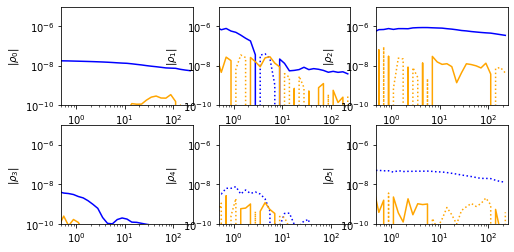

In [26]:
xi_s = np.genfromtxt(os.path.join(TARGET_DIR, "shear_small-scale_withIm_%d_%d.txt"%(0,0)), names=True)
xi_l = np.genfromtxt(os.path.join(TARGET_DIR, "shear_withIm_%d_%d.txt"%(0,0)), names=True)
r, xip = np.hstack([xi_s["r"], xi_l["r"]]), np.hstack([xi_s["xip"], xi_l["xip"]])
    
fig, axes = plt.subplots(2,3, figsize=(8,4))

axes[0,0].plot(pp['r_nom'], (pp['xip'])*1e-4, color='blue', ls='-')
axes[0,0].plot(pp['r_nom'], -(pp['xip'])*1e-4, color='blue', ls=':')
axes[0,0].plot(pp['r_nom'], (pp['xim'])*1e-4, color='orange', ls='-')
axes[0,0].plot(pp['r_nom'], -(pp['xim'])*1e-4, color='orange', ls=':')
#axes[0,0].plot(r, np.abs(xip)/1e-6, color='grey')
axes[0,0].set(xscale="log", yscale="log", ylabel=r'$\left|\rho_0\right|$')
axes[0,0].set(ylim=[1e-10, 1e-5], xlim=[0.5, 250])

axes[0,1].plot(qq['r_nom'], (qq['xip']), color='blue', ls='-')
axes[0,1].plot(qq['r_nom'], -(qq['xip']), color='blue', ls=':')
axes[0,1].plot(qq['r_nom'], (qq['xim']), color='orange', ls='-')
axes[0,1].plot(qq['r_nom'], -(qq['xim']), color='orange', ls=':')
#axes[0,1].plot(r, np.abs(xip), color='grey')
axes[0,1].set(xscale="log", yscale="log", ylabel=r'$\left|\rho_1\right|$')
axes[0,1].set(ylim=[1e-10, 1e-5], xlim=[0.5, 250])

axes[0,2].plot(qp['r_nom'], (qp['xip']), color='blue', ls='-')
axes[0,2].plot(qp['r_nom'], -(qp['xip']), color='blue', ls=':')
axes[0,2].plot(qp['r_nom'], (qp['xim']), color='orange', ls='-')
axes[0,2].plot(qp['r_nom'], -(qp['xim']), color='orange', ls=':')
#axes[0,2].plot(r, np.abs(xip)/2e-3, color='grey')
axes[0,2].set(xscale="log", yscale="log", ylabel=r'$\left|\rho_2\right|$')
axes[0,2].set(ylim=[1e-10, 1e-5], xlim=[0.5, 250])

axes[1,0].plot(ww['r_nom'], (ww['xip']), color='blue', ls='-')
axes[1,0].plot(ww['r_nom'], -(ww['xip']), color='blue', ls=':')
axes[1,0].plot(ww['r_nom'], (ww['xim']), color='orange', ls='-')
axes[1,0].plot(ww['r_nom'], -(ww['xim']), color='orange', ls=':')
#axes[1,0].plot(r, np.abs(xip), color='grey')
axes[1,0].set(xscale="log", yscale="log", ylabel=r'$\left|\rho_3\right|$')
axes[1,0].set(ylim=[1e-10, 1e-5], xlim=[0.5, 250])

axes[1,1].plot(wq['r_nom'], (wq['xip']), color='blue', ls='-')
axes[1,1].plot(wq['r_nom'], -(wq['xip']), color='blue', ls=':')
axes[1,1].plot(wq['r_nom'], (wq['xim']), color='orange', ls='-')
axes[1,1].plot(wq['r_nom'], -(wq['xim']), color='orange', ls=':')
#axes[1,1].plot(r, np.abs(xip)/2e-3, color='grey')
axes[1,1].set(xscale="log", yscale="log", ylabel=r'$\left|\rho_4\right|$')
axes[1,1].set(ylim=[1e-10, 1e-5], xlim=[0.5, 250])

axes[1,2].plot(wp['r_nom'], (wp['xip']), color='blue', ls='-')
axes[1,2].plot(wp['r_nom'], -(wp['xip']), color='blue', ls=':')
axes[1,2].plot(wp['r_nom'], (wp['xim']), color='orange', ls='-')
axes[1,2].plot(wp['r_nom'], -(wp['xim']), color='orange', ls=':')
#axes[1,2].plot(r, np.abs(xip)/2e-3, color='grey')
axes[1,2].set(xscale="log", yscale="log", ylabel=r'$\left|\rho_5\right|$')
axes[1,2].set(ylim=[1e-10, 1e-5], xlim=[0.5, 250])

plt.show()

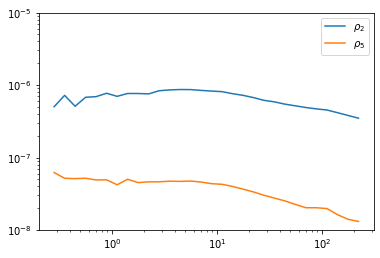

In [38]:
plt.plot(qp['r_nom'], np.abs(qp['xip']), label=r'$\rho_2$')
plt.plot(wp['r_nom'], np.abs(wp['xip']), label=r'$\rho_5$')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-8, 1e-5])
plt.legend()
plt.show()

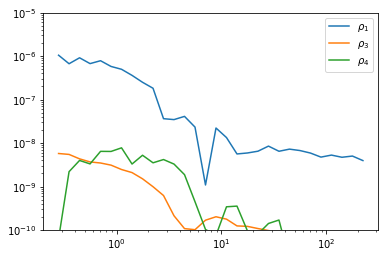

In [39]:
plt.plot(qq['r_nom'], np.abs(qq['xip']), label=r'$\rho_1$')
plt.plot(ww['r_nom'], np.abs(ww['xip']), label=r'$\rho_3$')
plt.plot(wq['r_nom'], np.abs(wq['xip']), label=r'$\rho_4$')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-10, 1e-5])
plt.legend()
plt.show()

In [40]:
# apply this changes to the data vector
# v3 includes new sompz file
dv_v3 = np.genfromtxt(os.path.join(TARGET_DIR, "xi_DESY3xPLKR4_6x2pt_Maglim_baseline_Ntheta30_v3.realdata"))
dv_v3[:600,1] -= additive_bias
np.savetxt(os.path.join(TARGET_DIR, "xi_DESY3xPLKR4_6x2pt_Maglim_baseline_Ntheta30_v4.realdata"), dv_v3, 
           fmt="%d %le")